In [1]:
!pip install fireducks polars plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 16.1.0
    Uninstalling pyarrow-16.1.0:
      Successfully uninstalled pyarrow-16.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.3 which is incompatible.


In [2]:
import os
import time

# disabling lazy-execution mode of FireDucks
os.environ["FIREDUCKS_FLAGS"] ="--benchmark-mode"

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/zvuk-dataset/zvuk-interactions.parquet
/kaggle/input/zvuk-dataset/zvuk-track_artist_embedding.parquet


In [3]:
results = {}
path = "/kaggle/input/zvuk-dataset/zvuk-interactions.parquet"

def append(lib, *args):
    results[lib] = list(args)
    
    
def bench_polars():
    stime = time.time()
    df = pl.read_parquet(path, columns=["datetime", "play_duration", "user_id"])
    load_t = time.time() - stime

    stime = time.time()
    no_na = df.drop_nulls()
    dropna_t = time.time() - stime

    stime = time.time()
    fdf = df.filter((pl.col('play_duration') > 0) & (pl.col('play_duration') < 1000))
    filter_t = time.time() - stime
    
    stime = time.time()
    desc = df['play_duration'].describe()
    desc_t = time.time() - stime

    stime = time.time()
    sdf = df['user_id'].value_counts(sort=True)
    vcount_t = time.time() - stime    
     
    stime = time.time()
    hour_wise_mean = (
        df.with_columns(
            pl.col("datetime").dt.hour().alias("hour"),
        )
        .group_by("hour").agg(pl.col("play_duration").mean())
    )
    group_agg_t = time.time() - stime
    
    # query combining groupby and sort to find top-10 users based on play_duration
    stime = time.time()
    user_wise_mean = (
        df.group_by("user_id").agg(pl.col("play_duration").mean()).sort("play_duration", descending=True).head(10)
    )
    top10_user_t = time.time() - stime

    append("polars", load_t, dropna_t, filter_t, desc_t, vcount_t, group_agg_t, top10_user_t)
    print(
        f"[polars] load-time: {load_t} sec; dropna-time: {dropna_t} sec; "
        f"filter-time: {filter_t} sec; describe-time: {desc_t} sec; "
        f"value-count-time: {vcount_t} sec; "
        f"group-agg-time: {group_agg_t} sec; top10-user-time: {top10_user_t} sec"
    )


def bench_others(pd):
    stime = time.time()
    df = pd.read_parquet(path, columns=["datetime", "play_duration", "user_id"])
    load_t = time.time() - stime

    stime = time.time()
    no_na = df.dropna()
    dropna_t = time.time() - stime
    
    stime = time.time()
    fdf = df[(df['play_duration'] > 0) & (df['play_duration'] < 1000)]
    filter_t = time.time() - stime

    stime = time.time()
    desc = df['play_duration'].describe()
    desc_t = time.time() - stime 
    
    stime = time.time()
    sdf = df['user_id'].value_counts(sort=True)
    vcount_t = time.time() - stime

    stime = time.time()
    hour_wise_mean = (
        df.assign(hour=lambda df: df["datetime"].dt.hour).groupby("hour")["play_duration"].mean()
    )
    group_agg_t = time.time() - stime
    
    # query combining groupby and sort to find top-10 users based on play_duration
    stime = time.time()
    user_wise_mean = (
        df.groupby("user_id")["play_duration"].mean().sort_values(ascending=False).head(10)
    )
    top10_user_t = time.time() - stime
    
    lib = pd.__name__
    append(lib, load_t, dropna_t, filter_t, desc_t, vcount_t, group_agg_t, top10_user_t)
    print(
        f"[{lib}] load-time: {load_t} sec; dropna-time: {dropna_t} sec; "
        f"filter-time: {filter_t} sec; desctibe-time: {desc_t} sec; "
        f"value-counts-time: {vcount_t} sec; "
        f"group-agg-time: {group_agg_t} sec; top10-user-time: {top10_user_t} sec"
    )
    
import pandas as pd
import fireducks.pandas as fd
import polars as pl

import platform, psutil
import fireducks

print("="*30, "Evaluation Environment Information", "="*30)
print(f'platform: {platform.system()}')
print(f'architecture: {platform.machine()}')
print(f'processor: {platform.processor()}')
print(f'cpu: {psutil.cpu_count()}')
print(f'ram: {str(round(psutil.virtual_memory().total / (1024 ** 3)))} GB')
print(f'pandas-version: {pd.__version__}')
print(f'fireducks-version: {fireducks.__version__}')
print(f'polars-version: {pl.__version__}')

import gc

# pandas and FireDucks share same APIs, hence same benchmark code can be used for both
for mod in [pd, fd]: 
    bench_others(mod)
    gc.collect()
    
# polars APIs are different, hence need to separate it out    
bench_polars()
gc.collect(); 

results = pd.DataFrame.from_dict(results)
results.index = ["load-time", "dropna-time", "filter-time", "describe-time", "value-count-time", "groupby-agg-time", "top10-user-time"]
results = round(results, 4)
results

============================== Evaluation Environment Information ==============================
platform: Linux
architecture: x86_64
processor: x86_64
cpu: 4
ram: 31 GB
pandas-version: 2.2.2
fireducks-version: 1.0.2
polars-version: 1.1.0
[pandas] load-time: 20.89788055419922 sec; dropna-time: 3.263585090637207 sec; filter-time: 9.821519136428833 sec; desctibe-time: 8.452152252197266 sec; value-counts-time: 2.3863284587860107 sec; group-agg-time: 13.429648637771606 sec; top10-user-time: 7.27917742729187 sec
[fireducks.pandas] load-time: 5.23788595199585 sec; dropna-time: 0.0016629695892333984 sec; filter-time: 2.9794867038726807 sec; desctibe-time: 9.319809436798096 sec; value-counts-time: 3.776824474334717 sec; group-agg-time: 2.574662685394287 sec; top10-user-time: 2.1672310829162598 sec
[polars] load-time: 6.380582332611084 sec; dropna-time: 0.05577421188354492 sec; filter-time: 2.6983559131622314 sec; describe-time: 9.346017837524414 sec; value-count-time: 9.177695989608765 sec; gr

,pandas,fireducks.pandas,polars
load-time,20.8979,5.2379,6.3806
dropna-time,3.2636,0.0017,0.0558
filter-time,9.8215,2.9795,2.6984
describe-time,8.4522,9.3198,9.3460
value-count-time,2.3863,3.7768,9.1777
groupby-agg-time,13.4296,2.5747,5.9670
top10-user-time,7.2792,2.1672,8.0225


In [4]:
!pip install plotly

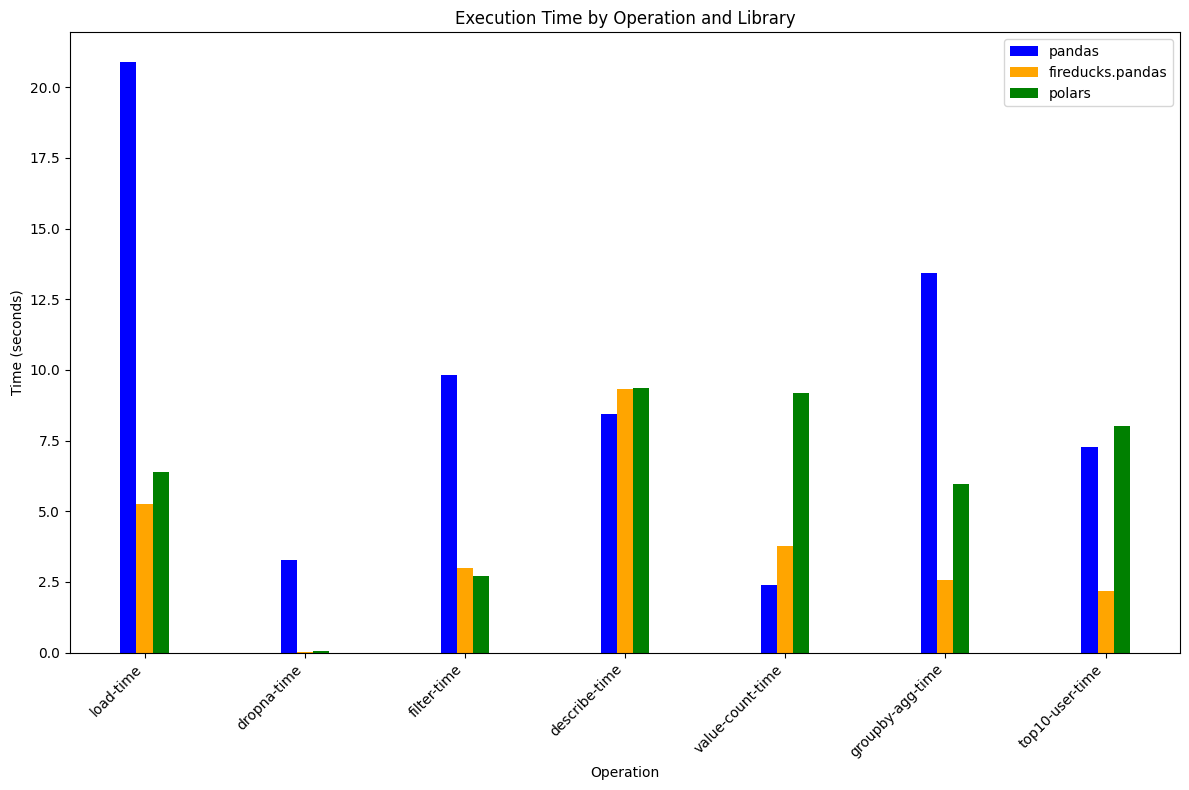

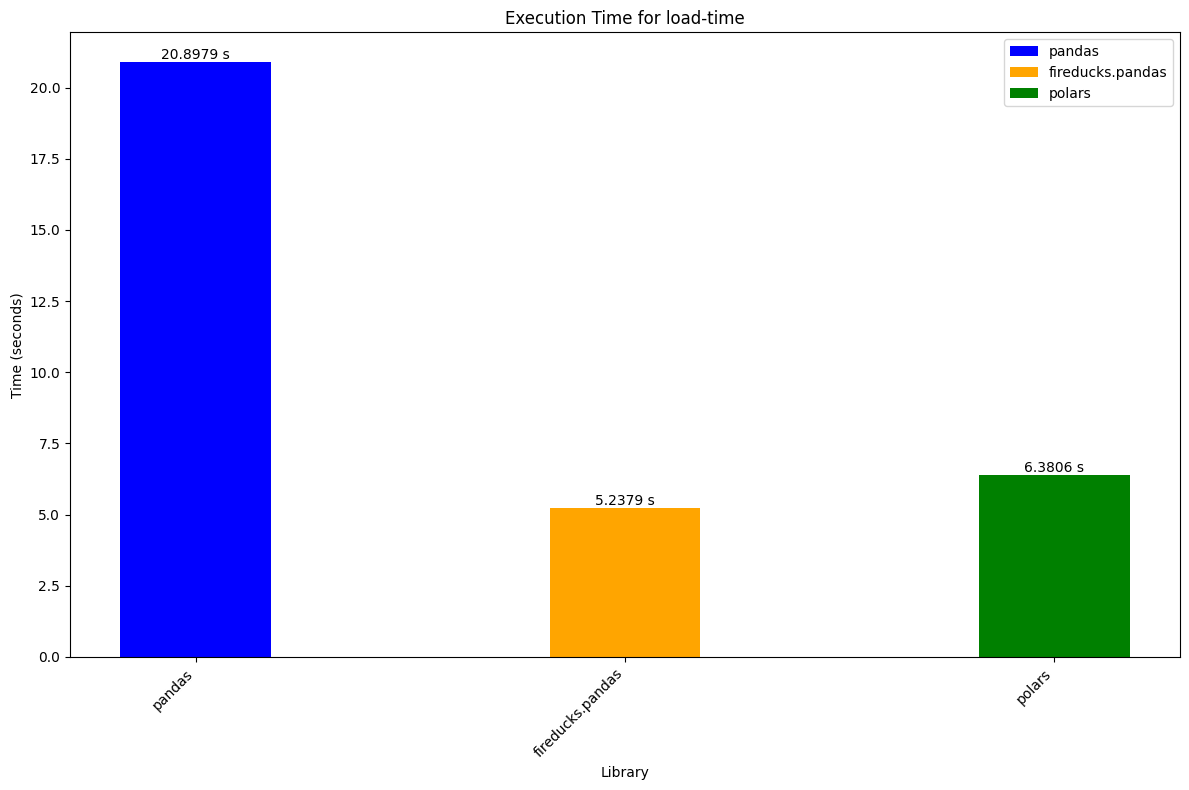

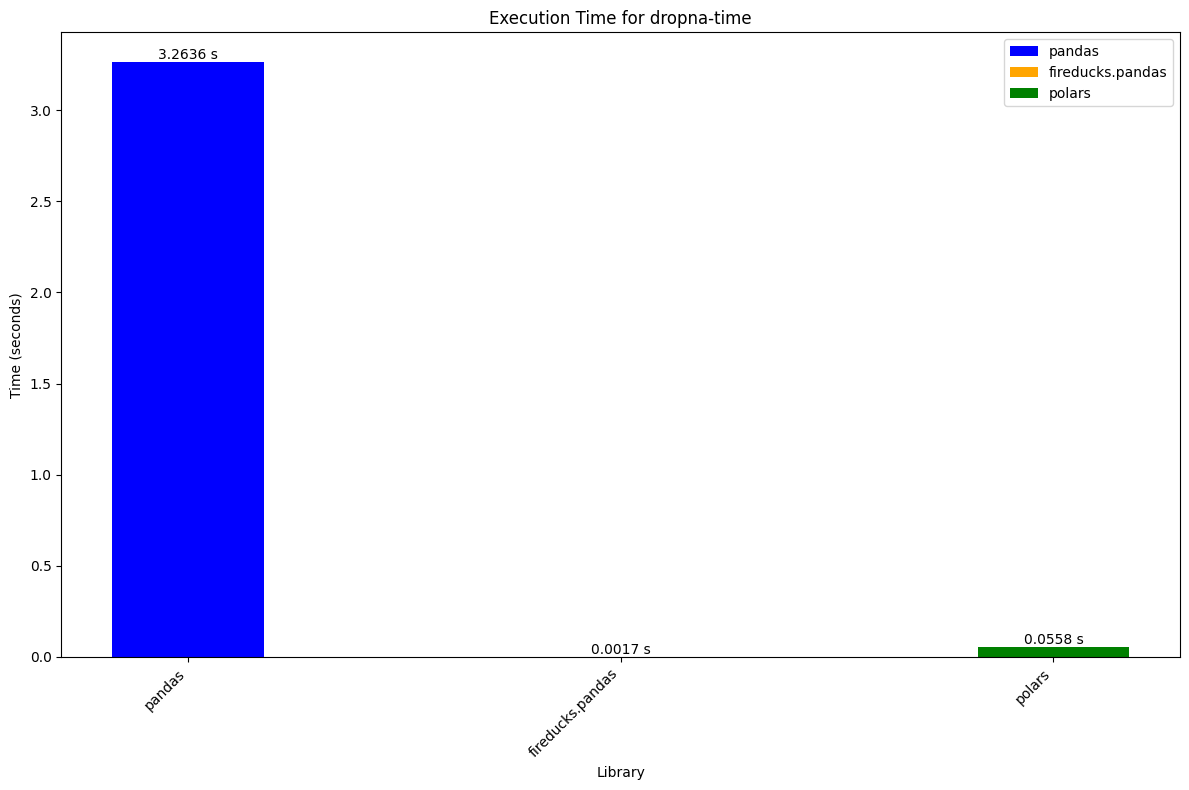

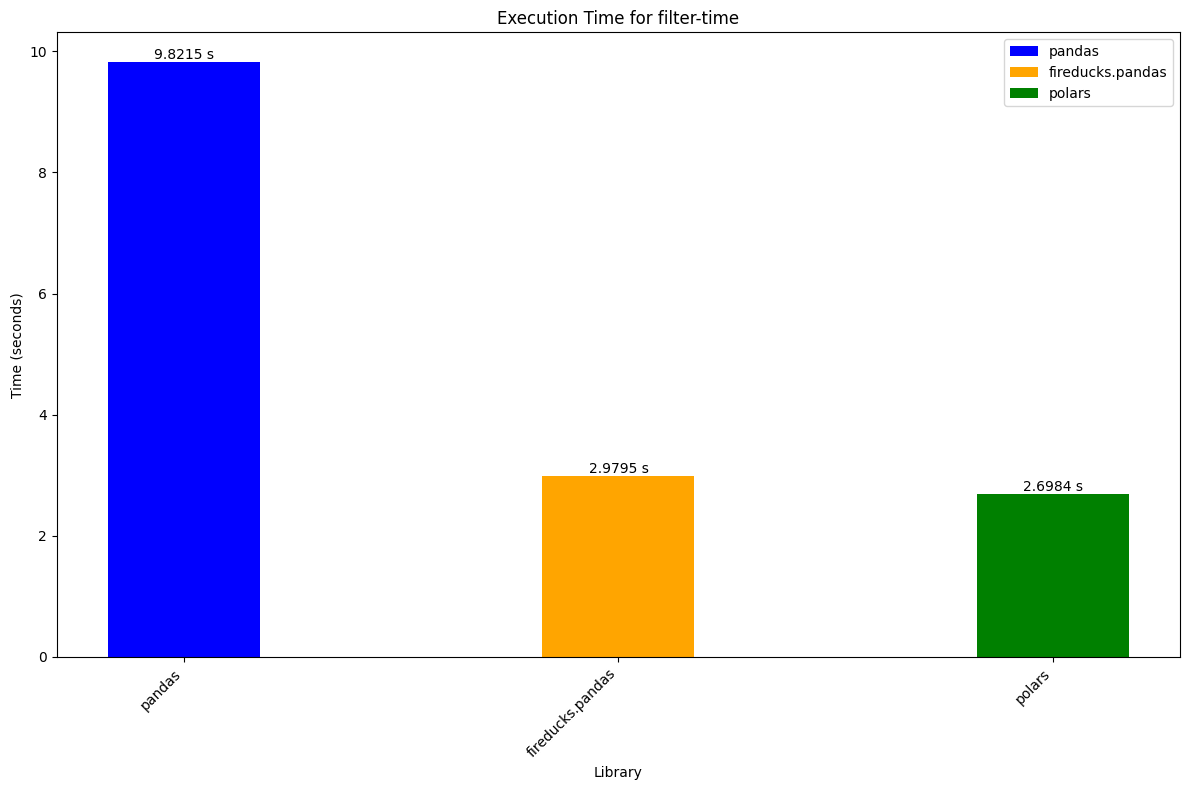

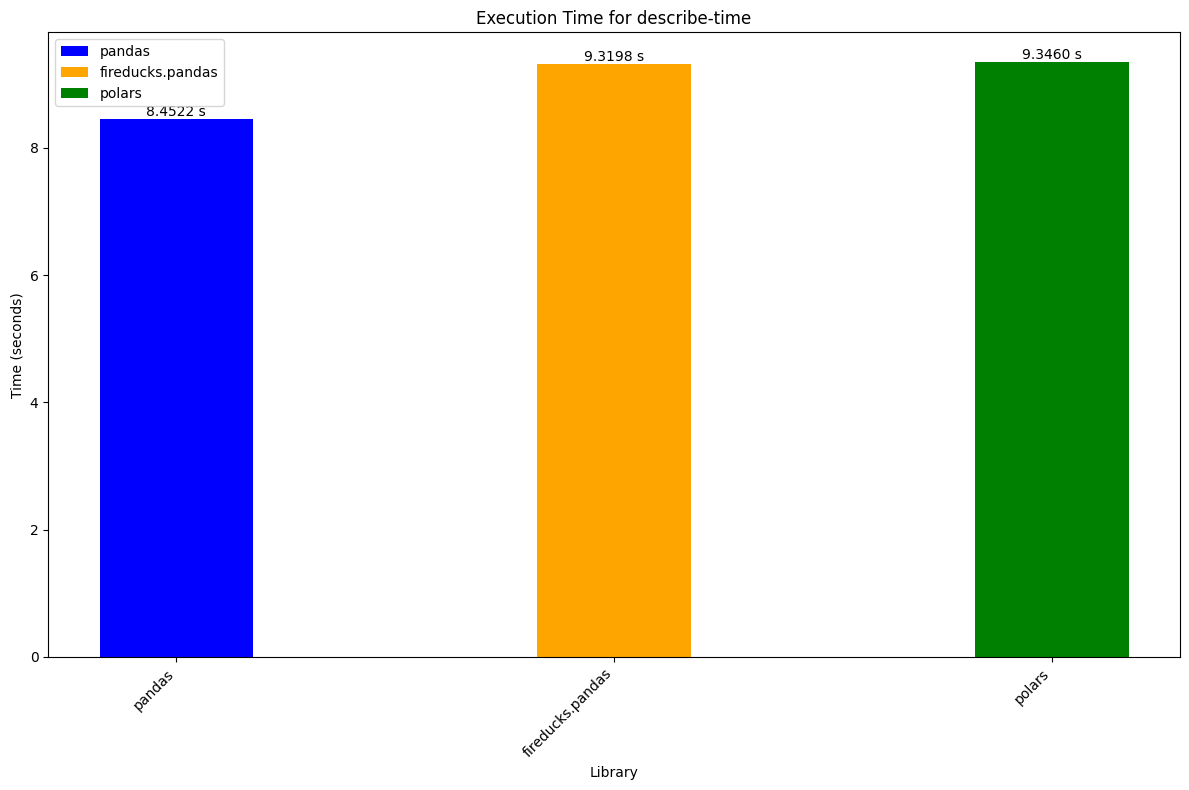

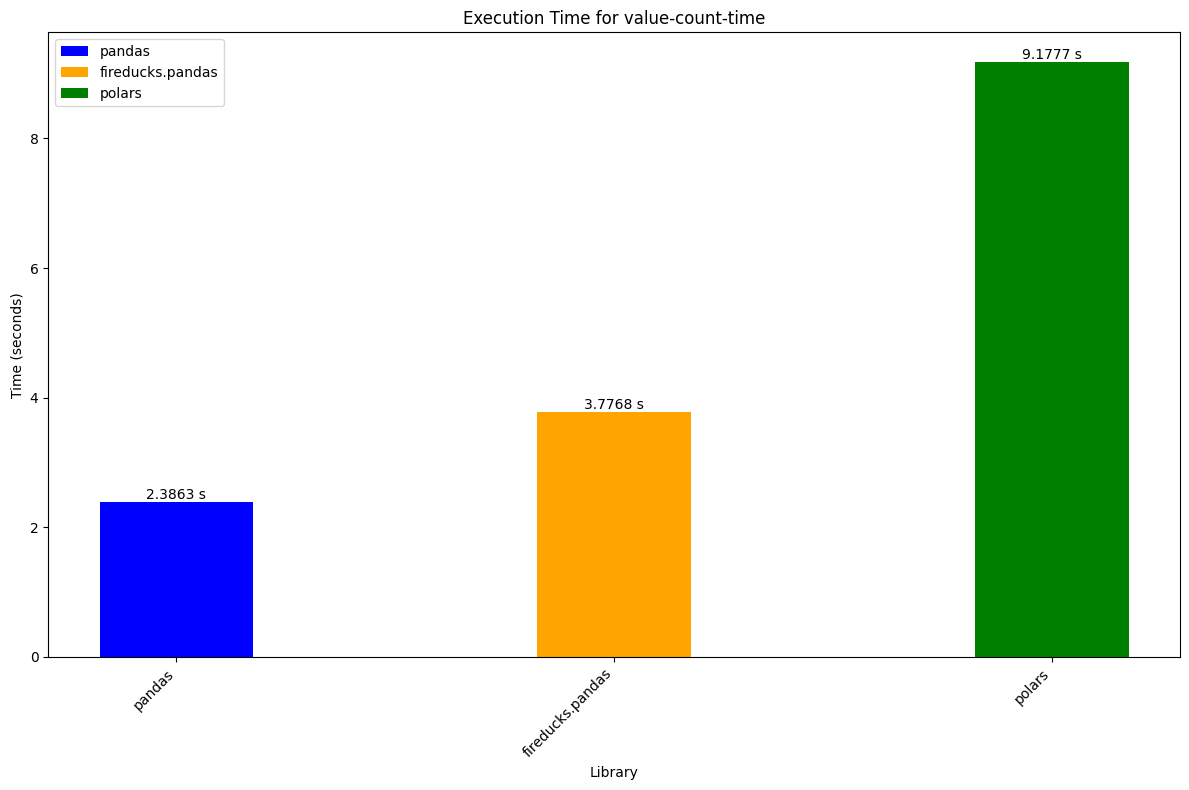

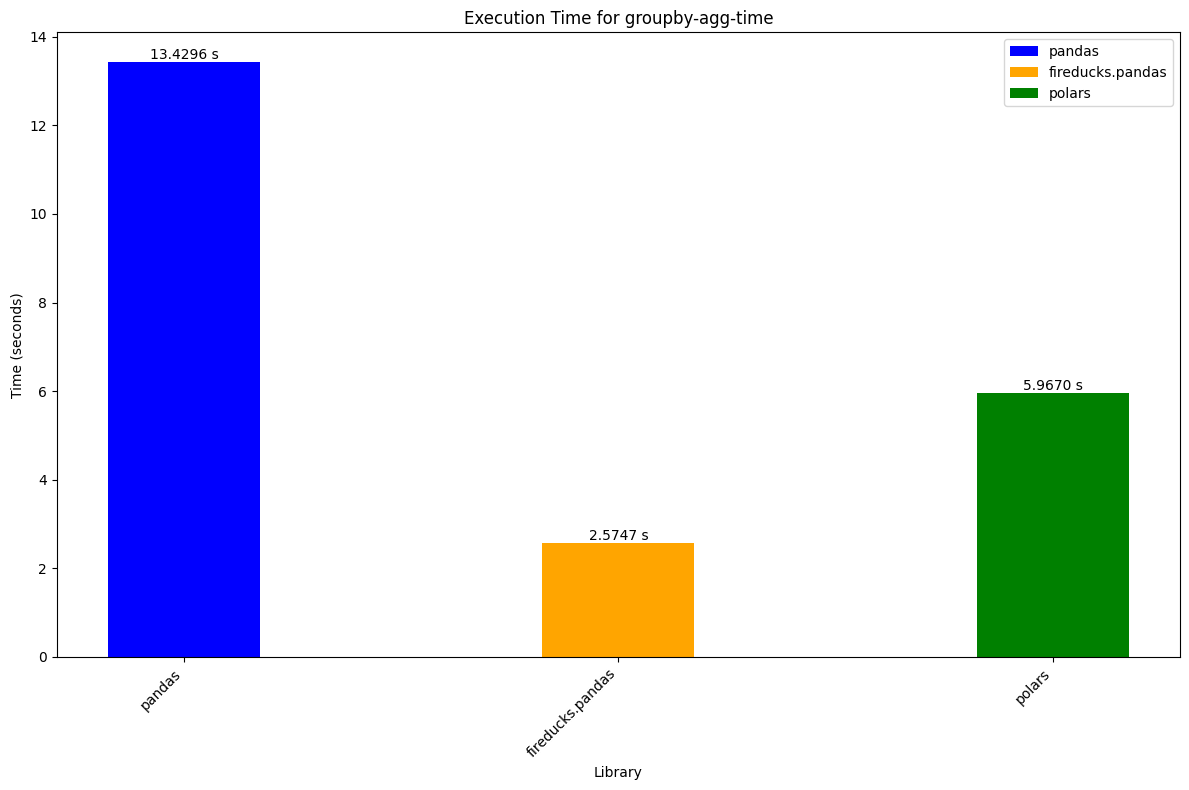

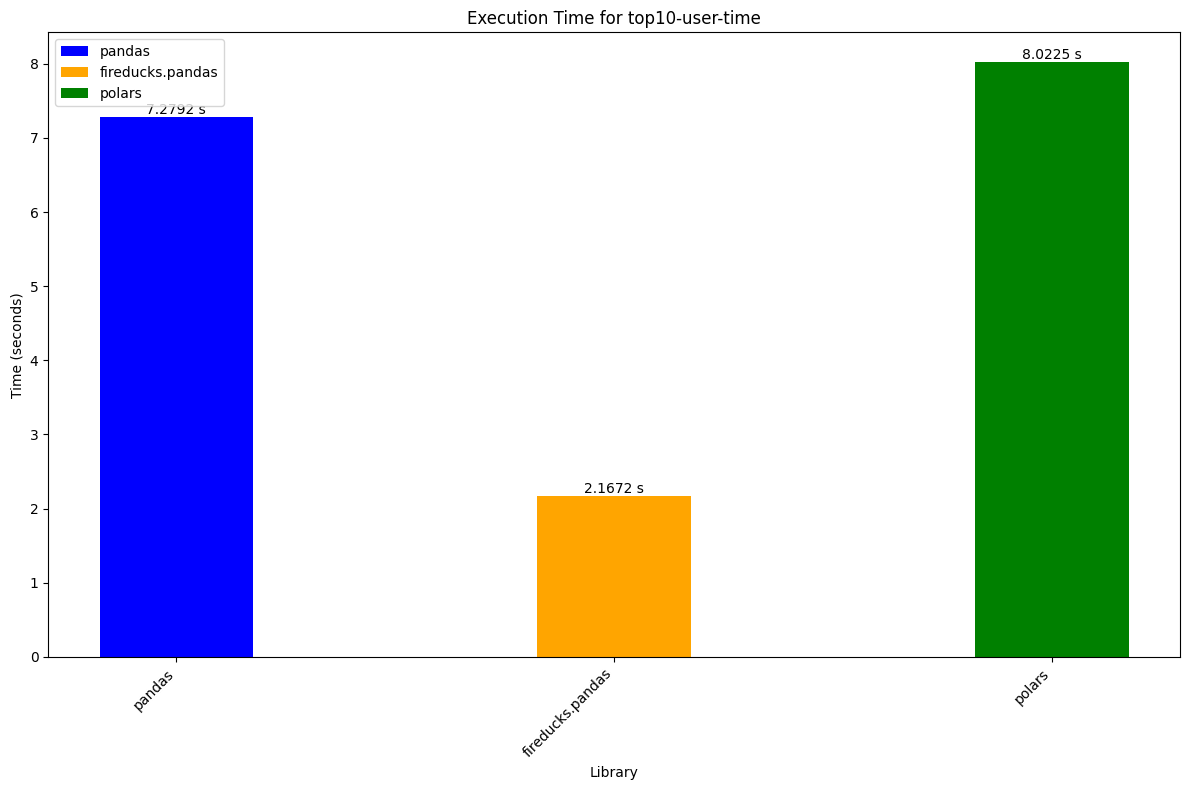

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Assuming `results` is your DataFrame
operations = results.index.tolist()
libraries = results.columns.tolist()
colors = ['blue', 'orange', 'green', 'red']  # Adjust colors as needed

# Combined plot for all operations
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1
index = np.arange(len(operations))

for i, lib in enumerate(libraries):
    times = results[lib].tolist()
    ax.bar(index + i * bar_width, times, bar_width, label=lib, color=colors[i])

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Execution Time by Operation and Library')
ax.set_xticks(index + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(operations, rotation=45, ha='right')
ax.legend()

# # Add annotations for time
# for i, op in enumerate(operations):
#     for j, lib in enumerate(libraries):
#         lib_time = results[lib][i]
#         ax.text(index[i] + j * bar_width, lib_time, f"{lib_time:.2f} s", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('execution_times_combined.png')
plt.show()

# Separate plots for each operation
for op in operations:
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35
    index = np.arange(len(libraries))
    times = results.loc[op].tolist()
    
    for i, lib in enumerate(libraries):
        time = times[i]
        ax.bar(index[i], time, bar_width, label=lib, color=colors[i])
        ax.text(index[i], time, f"{time:.4f} s", ha='center', va='bottom')
    
    ax.set_xlabel('Library')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Execution Time for {op}')
    ax.set_xticks(index)
    ax.set_xticklabels(libraries, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'{op}_execution_times.png')
    plt.show()

In [6]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Assuming `results` is your DataFrame
operations = results.index.tolist()
libraries = results.columns.tolist()
colors = ['blue', 'orange', 'green', 'red']  # Adjust colors as needed

# Function to set the aspect ratio of the figure
def set_aspect_ratio(fig, width=1200, height=800):
    fig.update_layout(
        autosize=False,
        width=width,
        height=height,
    )

# Combined plot for all operations
fig = go.Figure()

bar_width = 0.15  # Adjust this to make the bars slimmer
index = np.arange(len(operations))

for i, lib in enumerate(libraries):
    fig.add_trace(go.Bar(
        x=operations,
        y=results[lib].tolist(),
        name=lib,
        marker_color=colors[i],
        width=[bar_width] * len(operations)  # Set uniform width for all bars
    ))

# Set aspect ratio and improve layout
set_aspect_ratio(fig, width=1200, height=1000)
fig.update_layout(
    title='Execution Time by Operation and Library',
    xaxis_tickangle=-45,
    barmode='group',
    xaxis_title='Operation',
    yaxis_title='Time (seconds)',
    template='plotly_white',
    font=dict(
        family="Arial, sans-serif",
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

fig.show()

# Separate plots for each operation (with a slimmer bar width)
for op in operations:
    fig = go.Figure()

    for i, lib in enumerate(libraries):
        fig.add_trace(go.Bar(
            x=[lib],
            y=[results.loc[op][lib]],
            name=lib,
            marker_color=colors[i],
            width=[bar_width]  # Slimmer bars
        ))

    # Set aspect ratio and improve layout with a slimmer width
    set_aspect_ratio(fig, width=1200, height=1000)  # Adjust figure size
    fig.update_layout(
        title=f'Execution Time for {op}',
        xaxis_tickangle=-45,
        xaxis_title='Library',
        yaxis_title='Time (seconds)',
        template='plotly_white',
        font=dict(
            family="Arial, sans-serif",
            size=14,
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )

    fig.show()